## Python notebook 
V nasledujúcom notebooku sú popísané Python metódy použité pre zhlukovanie metódou k-Means. Obsah notebooku je nasledujúci:
1. Import potrebných knižníc
2. Vytvorenie autoenkódera
3. Načítanie a predspracovanie dát
4. Zhlukovanie

# 1. Import potrebných knižníc

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D, Dropout, Activation
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import sklearn.metrics
import random

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from tensorflow import keras
import time

# 2. Vytvorenie autoenkódera
Načítame dáta na trénovanie a validáciu enkódera a následne enkóder trénujeme na 40 epoch.

In [2]:
#nacitam data na trenovanie encodera
X_train = pickle.load(open('data/X_train.pkl', 'rb'))
y_train = pickle.load(open('data/y_train.pkl', 'rb'))

X_valid = pickle.load(open('data/X_valid.pkl', 'rb'))
y_valid = pickle.load(open('data/y_valid.pkl', 'rb'))

In [3]:
#normalizujem data
X_train = np.asarray(X_train, dtype=np.float32)/255
X_valid = np.asarray(X_valid, dtype=np.float32)/255

In [4]:
#overenie dat
print(X_train.shape)
print(X_valid.shape)

(2322, 150, 40, 3)
(175, 150, 40, 3)


In [5]:
#encoder
input_img = keras.Input(shape=(150, 40, 3))

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((3, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (25, 10, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((3, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 40, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 40, 64)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 20, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 10, 32)        9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 50, 20, 32)       

In [7]:
saved_model = "encoder_lowdim.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [8]:
history = autoencoder.fit(X_train, X_train, epochs = 40, validation_data=(X_valid, X_valid), batch_size = 32, callbacks = callbacks_list)

Epoch 1/40
73/73 [==============================] - ETA: 0s - loss: 0.4930
Epoch 00001: val_loss improved from inf to 0.44353, saving model to encoder_lowdim.hdf5
73/73 [==============================] - 1s 20ms/step - loss: 0.4930 - val_loss: 0.4435
Epoch 2/40
69/73 [===========================>..] - ETA: 0s - loss: 0.4393
Epoch 00002: val_loss improved from 0.44353 to 0.43397, saving model to encoder_lowdim.hdf5
73/73 [==============================] - 1s 16ms/step - loss: 0.4390 - val_loss: 0.4340
Epoch 3/40
73/73 [==============================] - ETA: 0s - loss: 0.4330
Epoch 00003: val_loss improved from 0.43397 to 0.43089, saving model to encoder_lowdim.hdf5
73/73 [==============================] - 1s 17ms/step - loss: 0.4330 - val_loss: 0.4309
Epoch 4/40
73/73 [==============================] - ETA: 0s - loss: 0.4297
Epoch 00004: val_loss improved from 0.43089 to 0.42725, saving model to encoder_lowdim.hdf5
73/73 [==============================] - 1s 17ms/step - loss: 0.4297 - v

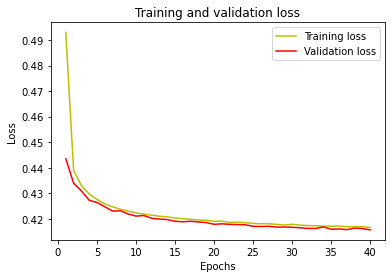

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Vizualizujeme obrázky na vstupe a výstupe enkódera pre kontrolu správnosti fungovania.

In [10]:
#load model
model = load_model('encoder_lowdim.hdf5')

In [11]:
#encodovanie a decodovanie dat
pred = model.predict(X_valid)

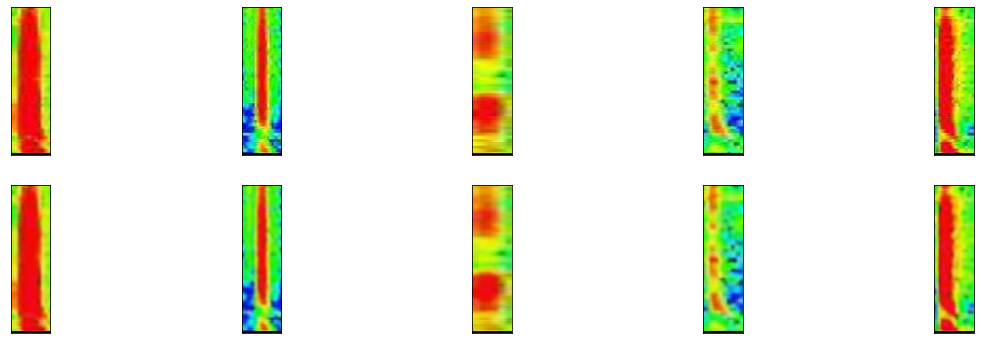

In [12]:
#vizualizovanie encodovanych a decodovanych dat
plt.figure(figsize=(20, 6))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_valid[i].reshape(150, 40, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(150, 40, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Vizualizujeme zakódovanú reprezentáciu dát

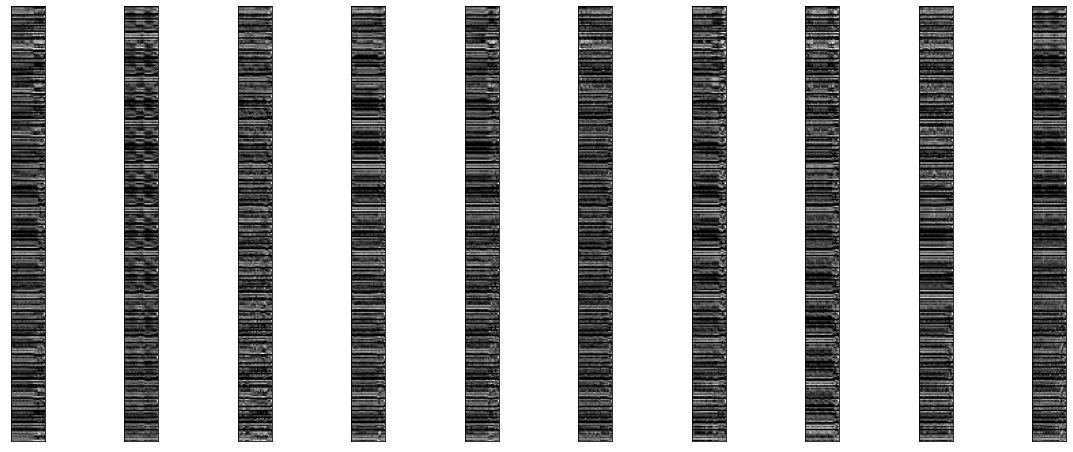

In [13]:
#vizualizovanie zakodovanej reprezentacie
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(X_valid)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((25, 10 * 32)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 3. Načítanie a predspracovanie dát
Načítame dáta pre zhlukovanie spolu s príslušnou výstupnou tabuľkou. Dáta zakódujeme pomocou autoenkódera a upravíme ich do tvaru vhodného pre model zhlukovania.

In [14]:
#nacitam data na clustering
data = pickle.load(open('data/data_2014_11.pkl', 'rb'))
label = pickle.load(open('data/label_2014_11.pkl', 'rb'))
img_name = pickle.load(open('data/img_name.pkl', 'rb'))

In [15]:
#nacitanie vystupnej tabulky
result = pd.read_csv("csv/result_2014_11_cleared.csv")
result

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0
...,...,...,...,...,...,...,...,...,...
13651,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0
13652,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0
13653,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0
13654,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0


In [16]:
#overenie dat
data.shape

(13647, 150, 40, 3)

In [17]:
label.shape

(13647,)

In [18]:
img_name.shape

(13647,)

In [19]:
#zakodovanie dat
encoded_images = encoder.predict(data)

In [20]:
encoded_images.shape

(13647, 25, 10, 32)

In [21]:
#reshape pre clustrovanie
to_cluster = encoded_images.reshape(-1, 25*10*32)

In [22]:
to_cluster.shape

(13647, 8000)

# 4. Zhlukovanie
Vyskúšali sme zhlukovanie do 2 až 9 zhlukov. Vytvorené zhluky sme vždy vizualizovali formou prvých 10 členov zhluku a informáciu o zhlukoch sme pridali do výstupnej tabuľky.

In [23]:
#clustering do 2 clustrov
kmeans = KMeans(n_clusters=2, random_state = 42)
clustered_training_set = kmeans.fit_predict(to_cluster)

In [24]:
len(clustered_training_set)

13647

In [25]:
#vytvorenie tabulky imgs s prisluchajucim clustrom
cluster_K2 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K2

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,1
1,ch2_20141130_185533_304_s41-S2.jpg,0
2,ch2_20141130_071513_250_s80-S6.jpg,0
3,ch2_20141130_161528_669_s90-S2.jpg,1
4,ch2_20141130_001501_274_s119-S3.jpg,0
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,0
13643,ch2_20141130_023005_152_s72-T3.jpg,0
13644,ch2_20141130_173030_842_s80-S6.jpg,0
13645,ch2_20141130_174031_139_s18-S8.jpg,0


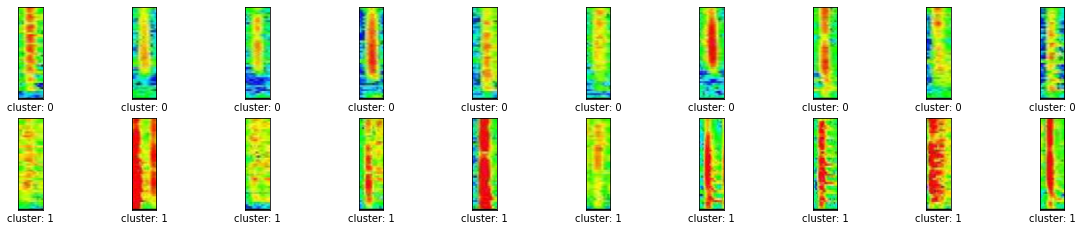

In [26]:
#vizualizacia clustrov
fig = plt.figure(figsize=(20,20))
for r in range(2):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/lowdim_kmeans_2clusters.png')

In [27]:
#spojenie clustrov s vystupnou tabulkou
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K2.set_index('img')['cluster'])

In [28]:
cluster_df.isnull().sum(axis = 0)

org_img       0
image         0
event         0
date          0
second        0
milisecond    0
tweek         0
f_min<2kHz    0
tweek_sign    0
cluster       9
dtype: int64

In [29]:
#vo vystupnej tabulke bol maly rozdiel v pocte poloziek (9) po spojeni vznikli null hodnoty, ktore sa vymazali
cluster_df = cluster_df.dropna()

In [30]:
cluster_df.isnull().sum(axis = 0)

org_img       0
image         0
event         0
date          0
second        0
milisecond    0
tweek         0
f_min<2kHz    0
tweek_sign    0
cluster       0
dtype: int64

In [31]:
cluster_df.count()

org_img       13647
image         13647
event         13647
date          13647
second        13647
milisecond    13647
tweek         13647
f_min<2kHz    13647
tweek_sign    13647
cluster       13647
dtype: int64

In [32]:
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,0
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,1
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,1
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,0
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,1
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,1
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,1
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,0


In [33]:
cluster_df.to_csv('cluster_csv/lowdim_K2_2014_11.csv', index=False)

In [34]:
#clustering 3 clustre
kmeans3 = KMeans(n_clusters=3, random_state = 42)
clustered_training_set = kmeans3.fit_predict(to_cluster)

In [35]:
len(clustered_training_set)

13647

In [36]:
#vytvorenie tabulky imgs s prisluchajucim clustrom
cluster_K3 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K3

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,1
1,ch2_20141130_185533_304_s41-S2.jpg,1
2,ch2_20141130_071513_250_s80-S6.jpg,0
3,ch2_20141130_161528_669_s90-S2.jpg,2
4,ch2_20141130_001501_274_s119-S3.jpg,0
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,1
13643,ch2_20141130_023005_152_s72-T3.jpg,1
13644,ch2_20141130_173030_842_s80-S6.jpg,0
13645,ch2_20141130_174031_139_s18-S8.jpg,1


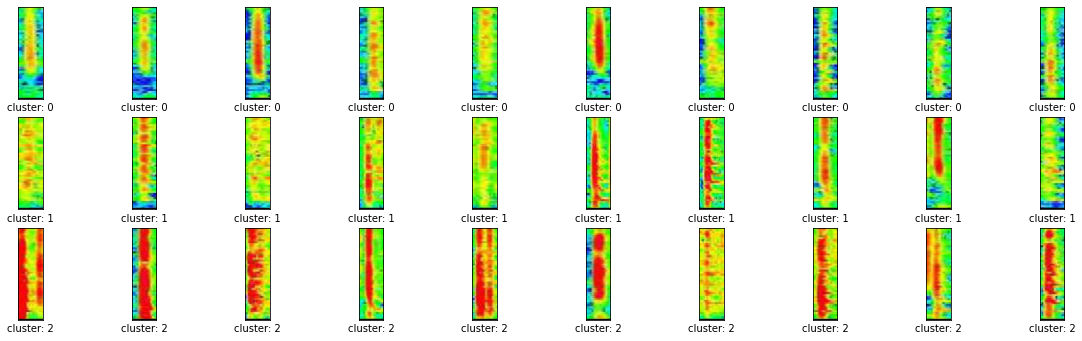

In [37]:
fig = plt.figure(figsize=(20,20))
for r in range(3):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/lowdim_kmeans_3clusters.png')
        #plt.ylabel('type: '+str(r))

In [38]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K3.set_index('img')['cluster'])

In [39]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,0
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,2
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,2
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,1
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,1
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,1
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,1
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,1


In [40]:
cluster_df.to_csv('cluster_csv/lowdim_K3_2014_11.csv', index=False)

In [41]:
#4 cluster
kmeans4 = KMeans(n_clusters=4, random_state = 42)
clustered_training_set = kmeans4.fit_predict(to_cluster)

In [42]:
len(clustered_training_set)

13647

In [43]:
cluster_K4 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K4

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,0
1,ch2_20141130_185533_304_s41-S2.jpg,0
2,ch2_20141130_071513_250_s80-S6.jpg,1
3,ch2_20141130_161528_669_s90-S2.jpg,3
4,ch2_20141130_001501_274_s119-S3.jpg,1
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,0
13643,ch2_20141130_023005_152_s72-T3.jpg,0
13644,ch2_20141130_173030_842_s80-S6.jpg,1
13645,ch2_20141130_174031_139_s18-S8.jpg,0


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(4):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/lowdim_kmeans_4clusters.png')
        #plt.ylabel('type: '+str(r))

In [45]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K4.set_index('img')['cluster'])

In [46]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,1
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,3
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,3
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,0
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,0
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,3
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,0
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,0


In [47]:
cluster_df.to_csv('cluster_csv/lowdim_K4_2014_11.csv', index=False)

In [48]:
kmeans5 = KMeans(n_clusters=5, random_state = 42)
clustered_training_set = kmeans5.fit_predict(to_cluster)

In [49]:
len(clustered_training_set)

13647

In [50]:
cluster_K5 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K5

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,4
1,ch2_20141130_185533_304_s41-S2.jpg,4
2,ch2_20141130_071513_250_s80-S6.jpg,1
3,ch2_20141130_161528_669_s90-S2.jpg,3
4,ch2_20141130_001501_274_s119-S3.jpg,1
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,2
13643,ch2_20141130_023005_152_s72-T3.jpg,0
13644,ch2_20141130_173030_842_s80-S6.jpg,2
13645,ch2_20141130_174031_139_s18-S8.jpg,2


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(5):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/lowdim_kmeans_5clusters.png')
        #plt.ylabel('type: '+str(r))

In [52]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K5.set_index('img')['cluster'])

In [53]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,1
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,3
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,3
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,2
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,4
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,4
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,4
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,4


In [54]:
cluster_df.to_csv('cluster_csv/lowdim_K5_2014_11.csv', index=False)

In [55]:
#6clusters
kmeans6 = KMeans(n_clusters=6, random_state = 42)
clustered_training_set = kmeans6.fit_predict(to_cluster)

In [56]:
len(clustered_training_set)

13647

In [57]:
cluster_K6 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K6

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,5
1,ch2_20141130_185533_304_s41-S2.jpg,5
2,ch2_20141130_071513_250_s80-S6.jpg,1
3,ch2_20141130_161528_669_s90-S2.jpg,3
4,ch2_20141130_001501_274_s119-S3.jpg,1
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,2
13643,ch2_20141130_023005_152_s72-T3.jpg,0
13644,ch2_20141130_173030_842_s80-S6.jpg,2
13645,ch2_20141130_174031_139_s18-S8.jpg,2


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(6):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/lowdim_kmeans_6clusters.png')
        #plt.ylabel('type: '+str(r))

In [59]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K6.set_index('img')['cluster'])

In [60]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,1
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,3
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,3
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,2
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,5
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,5
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,5
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,5


In [61]:
cluster_df.to_csv('cluster_csv/lowdim_K6_2014_11.csv', index=False)

In [62]:
#7clusters
kmeans7 = KMeans(n_clusters=7, random_state = 42)
clustered_training_set = kmeans7.fit_predict(to_cluster)

In [63]:
len(clustered_training_set)

13647

In [64]:
cluster_K7 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K7

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,0
1,ch2_20141130_185533_304_s41-S2.jpg,5
2,ch2_20141130_071513_250_s80-S6.jpg,2
3,ch2_20141130_161528_669_s90-S2.jpg,6
4,ch2_20141130_001501_274_s119-S3.jpg,2
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,5
13643,ch2_20141130_023005_152_s72-T3.jpg,5
13644,ch2_20141130_173030_842_s80-S6.jpg,4
13645,ch2_20141130_174031_139_s18-S8.jpg,5


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(7):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/lowdim_kmeans_7clusters.png')
        #plt.ylabel('type: '+str(r))

In [66]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K7.set_index('img')['cluster'])

In [67]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,2
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,6
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,6
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,3
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,0
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,0
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,0
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,5


In [68]:
cluster_df.to_csv('cluster_csv/lowdim_K7_2014_11.csv', index=False)

In [69]:
#8clusters
kmeans8 = KMeans(n_clusters=8, random_state = 42)
clustered_training_set = kmeans8.fit_predict(to_cluster)

In [70]:
len(clustered_training_set)

13647

In [71]:
cluster_K8 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K8

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,0
1,ch2_20141130_185533_304_s41-S2.jpg,6
2,ch2_20141130_071513_250_s80-S6.jpg,3
3,ch2_20141130_161528_669_s90-S2.jpg,2
4,ch2_20141130_001501_274_s119-S3.jpg,3
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,6
13643,ch2_20141130_023005_152_s72-T3.jpg,6
13644,ch2_20141130_173030_842_s80-S6.jpg,1
13645,ch2_20141130_174031_139_s18-S8.jpg,6


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(8):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/lowdim_kmeans_8clusters.png')
        #plt.ylabel('type: '+str(r))

In [73]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K8.set_index('img')['cluster'])

In [74]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,3
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,2
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,2
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,5
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,0
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,0
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,0
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,6


In [75]:
cluster_df.to_csv('cluster_csv/lowdim_K8_2014_11.csv', index=False)

In [76]:
9#clusters
kmeans9 = KMeans(n_clusters=9, random_state = 42)
clustered_training_set = kmeans9.fit_predict(to_cluster)

In [77]:
len(clustered_training_set)

13647

In [78]:
cluster_K9 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K9

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,1
1,ch2_20141130_185533_304_s41-S2.jpg,3
2,ch2_20141130_071513_250_s80-S6.jpg,0
3,ch2_20141130_161528_669_s90-S2.jpg,8
4,ch2_20141130_001501_274_s119-S3.jpg,0
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,5
13643,ch2_20141130_023005_152_s72-T3.jpg,2
13644,ch2_20141130_173030_842_s80-S6.jpg,4
13645,ch2_20141130_174031_139_s18-S8.jpg,3


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(9):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/lowdim_kmeans_9clusters.png')
        #plt.ylabel('type: '+str(r))

In [80]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K9.set_index('img')['cluster'])

In [81]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,0
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,6
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,8
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,2
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,1
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,1
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,1
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,3


In [82]:
cluster_df.to_csv('cluster_csv/lowdim_K9_2014_11.csv', index=False)